# HW10_cjs676 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

Do the same analysis for a different season in HW10_<netID>/Assignment2_<netID>.ipynb, and see if the spatial autocorrelation changes and, if yes, how it differs from winter to summer. Describe the seasonal effects in your README file for HW10_<netID>/README.md

## Import initial libraries

Collected all the randomly placed imports

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
from matplotlib import colors
import seaborn as sns
from geopandas import GeoDataFrame
from fiona.crs import from_epsg
import pysal as ps
import shapely
import statsmodels.api as sm

## Working with Shape File

### Loading Census Tract Shape File¶

In [3]:

shape_path="Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [4]:

ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

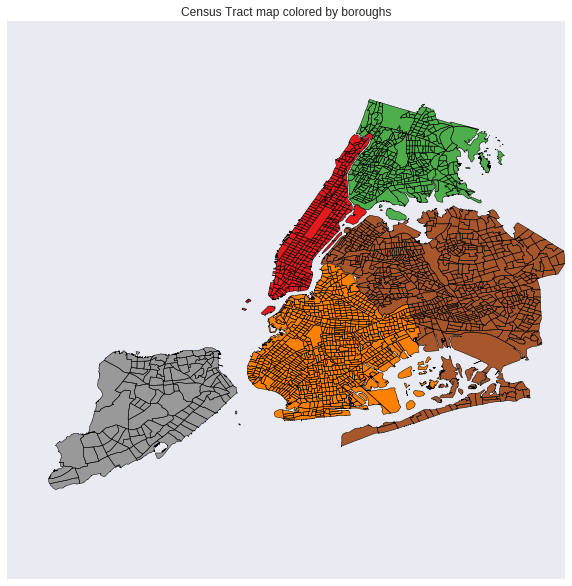

In [5]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

### Map NYC Population density

#### Load Census Data for 2010

In [6]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [7]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

/opt/rh/anaconda/root/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


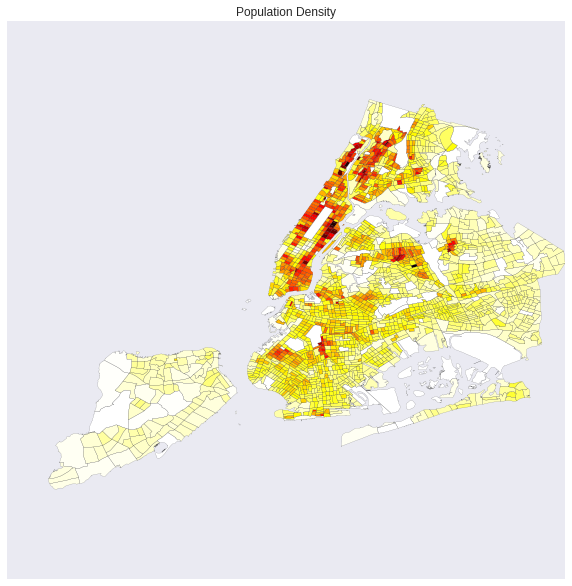

In [8]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

## Explore CitiBike data

### Load CitiBike data

In [95]:
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Time Series Aanalysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

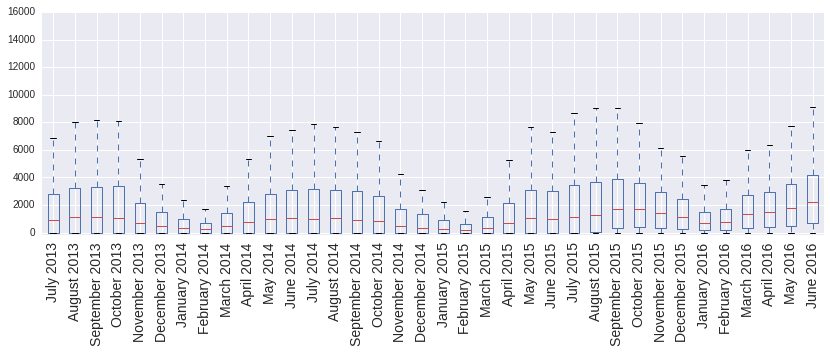

In [96]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

#### Seasonal Decomposition

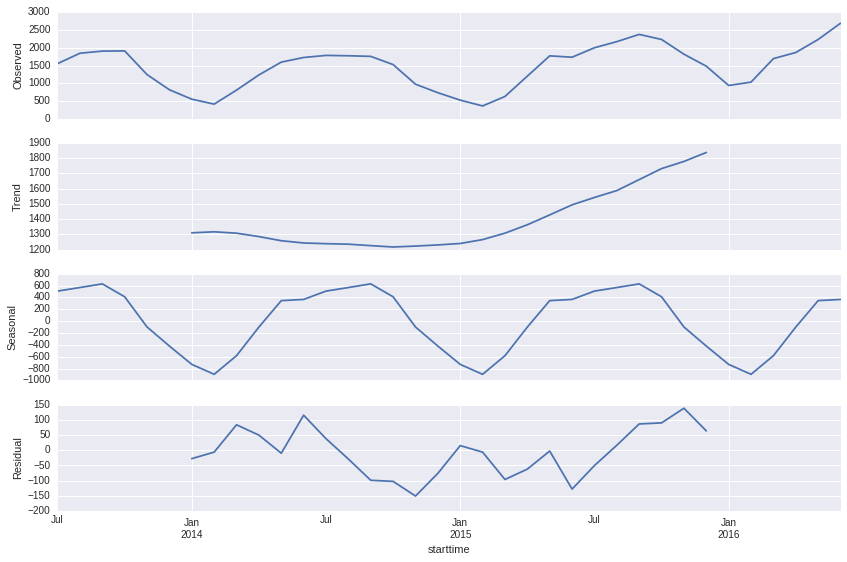

In [97]:


#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [98]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [99]:

# combine lat and lon to one column
station_id['lonlat'] = zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry'] = station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [100]:
a=[]
# check for each citibike stations to see what CT they belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%", str((i + 1) * 100. / len(station_id))[:4],
station_id['BoroCT2010'] = a

% 100.


In [101]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

In [84]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
##station_id['MonthlyAve'] = df_bike_monthly.sum()

In [102]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100


In [86]:
len(station_id)

543

##Staring here I will attempt to pull out the wintr months from the summer months

First take a look at the data

In [87]:
df_bike_monthly.head()

,starttime,1000,1001,1002,1003,1004,1005,1006,1007,1008,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
0,2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,...,0,0,0,0,0,0,0,0,0,0
1,2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,...,0,0,0,0,0,0,0,0,0,0
2,2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,...,0,0,0,0,0,0,0,0,0,0
3,2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,...,0,0,0,0,0,0,0,0,0,0
4,2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,...,0,0,0,0,0,0,0,0,0,0


In [76]:
len(df_bike_monthly)

36

Winter = December (12), January (01) and February (02)

Summer = June (06), Jul7 (07), August (08)

After some trial and error I realized I had to make a new index 
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html
DataFrame.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill=''


In [88]:
df_bike_monthly.reset_index(inplace=True)

In [89]:
df_bike_monthly.head()

,index,starttime,1000,1001,1002,1003,1004,1005,1006,1007,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
0,0,2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,...,0,0,0,0,0,0,0,0,0,0
1,1,2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,...,0,0,0,0,0,0,0,0,0,0
2,2,2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,...,0,0,0,0,0,0,0,0,0,0
3,3,2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,...,0,0,0,0,0,0,0,0,0,0
4,4,2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,...,0,0,0,0,0,0,0,0,0,0



I am going to try this techniques to get the values I want
http://stackoverflow.com/questions/31128477/how-to-set-values-based-on-a-list-in-pandas-python

Here is the documentation for pandas .isin
http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.DataFrame.isin.html

some_list = [2, 3]
df.loc[df['month'].isin(some_list), 'x'] = 99



I couldnt get it to just pull out the month so i am going to do it the dumb way and just pull out all the dates I want. 

In [91]:
wintermonths = ['2016-02-29', '2016-01-31', '2015-12-31', '2015-02-28', '2015-01-31', '2014-12-31', '2014-02-28', 
                '2014-01-31', '2013-12-31']
##Create the winter dataframe
df_citibike_winter = df_bike_monthly.loc[df_bike_monthly['starttime'].isin(wintermonths)]


In [92]:
df_citibike_winter.head()

,index,starttime,1000,1001,1002,1003,1004,1005,1006,1007,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
5,5,2013-12-31,1299,1650,4081,1686,3046,1575,830,1890,...,0,0,0,0,0,0,0,0,0,0
6,6,2014-01-31,956,1337,3178,1251,1920,1130,477,1412,...,0,0,0,0,0,0,0,0,0,0
7,7,2014-02-28,650,960,2920,676,1808,933,508,1045,...,0,0,0,0,0,0,0,0,0,0
17,17,2014-12-31,1052,1304,4501,1783,2985,2091,779,2108,...,0,0,0,0,0,0,0,0,0,0
18,18,2015-01-31,833,0,3186,1248,1992,1429,442,1499,...,0,0,0,0,0,0,0,0,0,0


Create the summer dataframe


In [93]:
summermonths = ['2013-07-31', '2013-08-31', '2014-06-30', '2014-07-31', '2014-08-31', '2015-06-30', '2015-07-31', 
                '2015-08-31', '2016-06-30']
##Create the summer dataframe
df_citibike_summer = df_bike_monthly.loc[df_bike_monthly['starttime'].isin(summermonths)]

In [94]:
df_citibike_summer.head()

,index,starttime,1000,1001,1002,1003,1004,1005,1006,1007,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
0,0,2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,...,0,0,0,0,0,0,0,0,0,0
1,1,2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,...,0,0,0,0,0,0,0,0,0,0
11,11,2014-06-30,2048,3306,9626,3515,7255,2942,1917,3702,...,0,0,0,0,0,0,0,0,0,0
12,12,2014-07-31,2252,3216,9825,3509,7014,3224,2195,3732,...,0,0,0,0,0,0,0,0,0,0
13,13,2014-08-31,2179,3004,10196,3573,7328,3311,2213,4078,...,0,0,0,0,0,0,0,0,0,0


Add Monthly rides to the station GeoDataFrame with CT code

Instead of a just adding one field as was done in the example I will add two one for winter and one for summer. Since they are summed the zeros wont matter. 

In [104]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['SummerAve']=df_citibike_summer.sum()
station_id['WinterAve']=df_citibike_winter.sum()

In [105]:
station_id.head()


,lat,lon,lonlat,geometry,BoroCT2010,SummerAve,WinterAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,22422,9456
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,32869,11373
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,87375,36543
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,33018,14170
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,59890,21889


### Add the monthly average rides to the CT shapefile 

In [106]:
# use the 
temp=station_id[['SummerAve', 'WinterAve']]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']
ct_shape_MonthlyAve=ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Plot the summer average

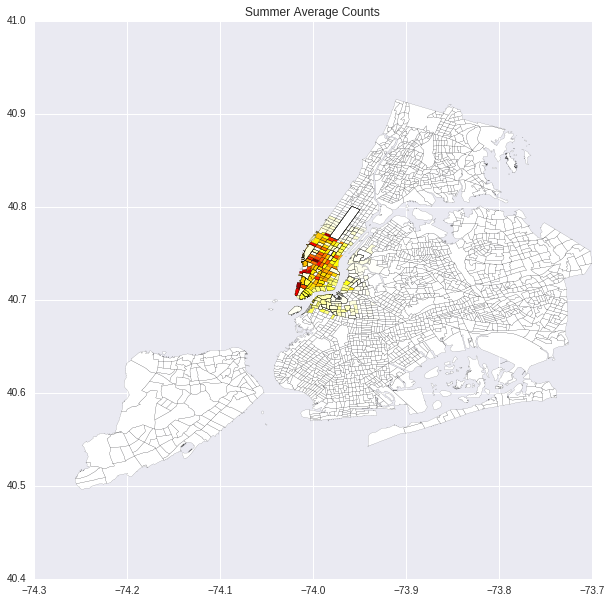

In [107]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve.plot(column='SummerAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Ride Counts")

Plot the winter average

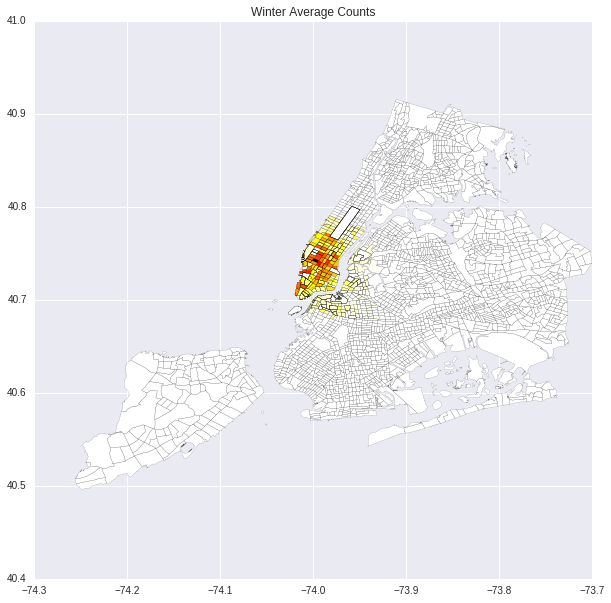

In [118]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve.plot(column='WinterAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Ride Counts")
plt.legend(colormap='hot_r')

### Removing the CTs that are out of zoom boundries

In [110]:
ct_shape_MonthlyAve_Zoom=(ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [113]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.WinterAve)
print "Number of zoomed CTs:", len(temp.SummerAve)

 Total number of CTs: 2166
Number of zoomed CTs: 543
Number of zoomed CTs: 543


In [116]:
#Make nice plots and also side by side
#plt.xlabel('xlabel', fontsize=18)
#plt.ylabel('ylabel', fontsize=16)

(-74.1, -73.9)

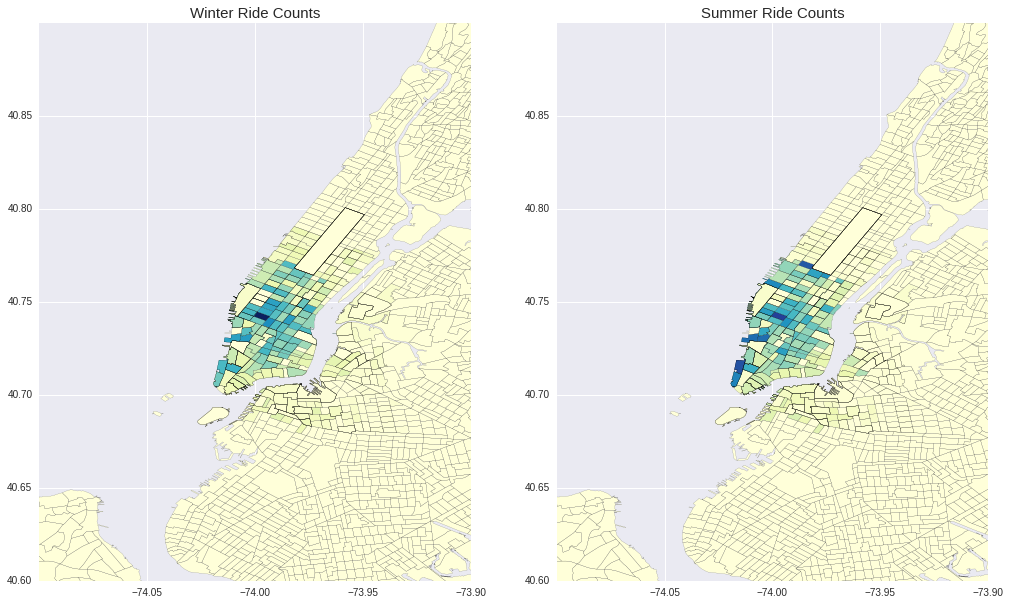

In [195]:
fig, ax = plt.subplots(1, 2, figsize=(17,10))

ct_shape_MonthlyAve.plot(column='WinterAve',colormap='YlGnBu',alpha=1,linewidth=0.1,ax=ax[0])
ax[0].set_title('Winter Ride Counts', fontsize = 15)
ax[0].set_ylim([40.6, 40.9])
ax[0].set_xlim([-74.1, -73.9])



ct_shape_MonthlyAve.plot(column='SummerAve',colormap='YlGnBu',alpha=1,linewidth=0.1,ax=ax[1])
ax[1].set_title('Summer Ride Counts', fontsize = 15)
ax[1].set_ylim([40.6, 40.9])
ax[1].set_xlim([-74.1, -73.9])

### Map the monthly rides 

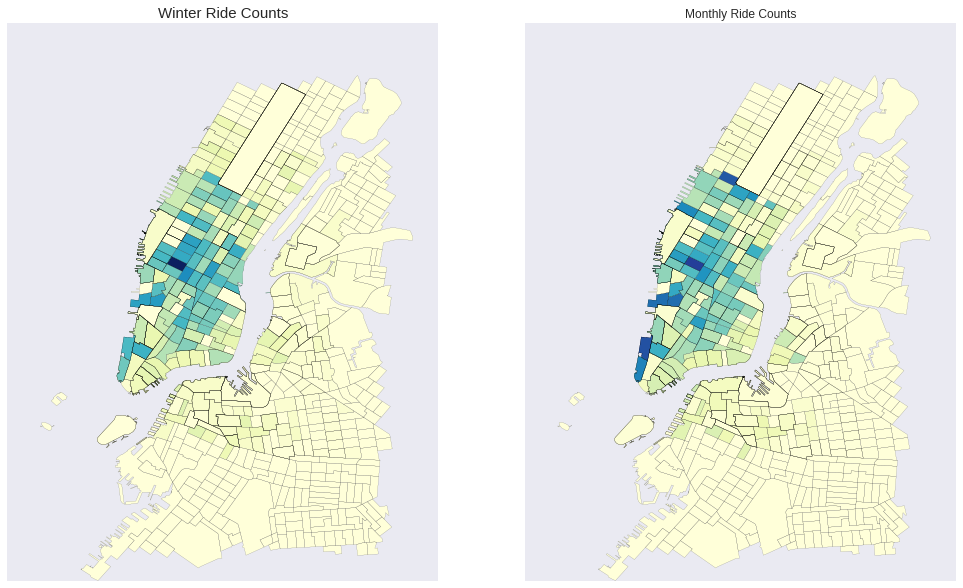

In [129]:
fig, ax = plt.subplots(1, 2, figsize=(17,10))

ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='WinterAve',colormap='YlGnBu',alpha=1,linewidth=0.1,ax=ax[0])
ax[0].set_title('Winter Ride Counts', fontsize = 15)

ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='SummerAve',colormap='YlGnBu',alpha=1,linewidth=0.1,ax=ax[1])
ax[1].set_title('Summer Ride Counts', fontsize = 15)

plt.title("Monthly Ride Counts")

### Export Shapefile CTs in the CitiBike Zone

In [130]:
path = 'Output/ct_shape_SeasonalMonthlyAve_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [131]:
qW_CT = ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [132]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [133]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [134]:
Wmatrix, ids = qW_CT.full()

In [135]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [136]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [143]:
WinterRide=ct_shape_MonthlyAve_Zoom.WinterAve
WinterRideLag=ps.lag_spatial(qW_CT, WinterRide)
SummerRide=ct_shape_MonthlyAve_Zoom.SummerAve
SummerRideLag=ps.lag_spatial(qW_CT, SummerRide)

#### Create Quantiles for maping

In [144]:
WinterRideLagQ10 = ps.Quantiles(WinterRideLag, k=10)
WinterRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    36.286                 2
   36.286 < x[i] <=   603.729                78
  603.729 < x[i] <=  1458.923                80
 1458.923 < x[i] <=  2284.227                79
 2284.227 < x[i] <=  3278.714                80
 3278.714 < x[i] <=  7763.237                79
 7763.237 < x[i] <= 10456.870                80
10456.870 < x[i] <= 12783.385                79
12783.385 < x[i] <= 20551.286                80

In [145]:
SummerRideLagQ10 = ps.Quantiles(SummerRideLag, k=10)
SummerRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    49.286                 2
   49.286 < x[i] <=   882.900                78
  882.900 < x[i] <=  2346.833                80
 2346.833 < x[i] <=  5645.067                84
 5645.067 < x[i] <=  8593.933                75
 8593.933 < x[i] <= 19189.030                79
19189.030 < x[i] <= 27831.071                80
27831.071 < x[i] <= 32327.735                79
32327.735 < x[i] <= 49147.643                80

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(17,10))

ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='WinterAve',colormap='YlGnBu',alpha=1,linewidth=0.1,ax=ax[0])
ax[0].set_title('Winter Ride Counts', fontsize = 15)

ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='SummerAve',colormap='YlGnBu',alpha=1,linewidth=0.1,ax=ax[1])
ax[1].set_title('Summer Ride Counts', fontsize = 15)

plt.title("Monthly Ride Counts")

#### Map the monthly rides lag

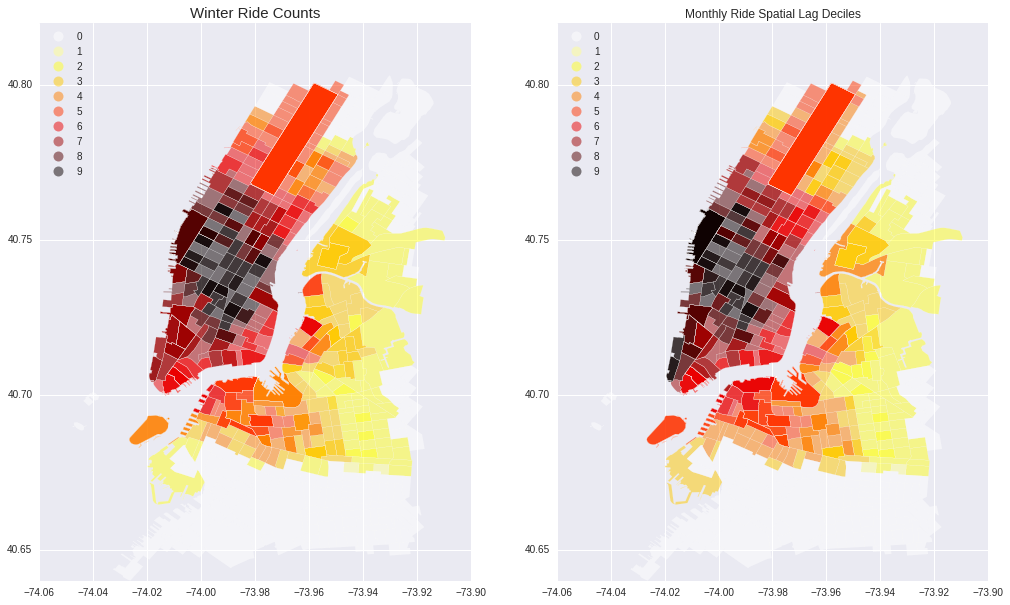

In [148]:
fig, ax = plt.subplots(1, 2, figsize=(17,10))

ct_shape_MonthlyAve_Zoom.assign(cl=WinterRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax[0], 
        edgecolor='white', legend=True)
ax[0].set_title('Winter Ride Counts', fontsize = 15)

ct_shape_MonthlyAve_Zoom.assign(cl=SummerRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax[1], 
        edgecolor='white', legend=True)
ax[1].set_title('Summer Ride Counts', fontsize = 15)



plt.title("Monthly Ride Spatial Lag Deciles")


## Global  Spatial Autocorrelation

np.polyfit reference
https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.polyfit.html

In [150]:
b, a = np.polyfit(WinterRide, WinterRideLag, 1)
b, a 

(0.66023249858156818, 1600.8324238675889)

In [151]:
b1, a1 = np.polyfit(SummerRide, SummerRideLag, 1)
b1, a1 

(0.64335490815356511, 4220.5552980795601)

### Moran Scatterplot

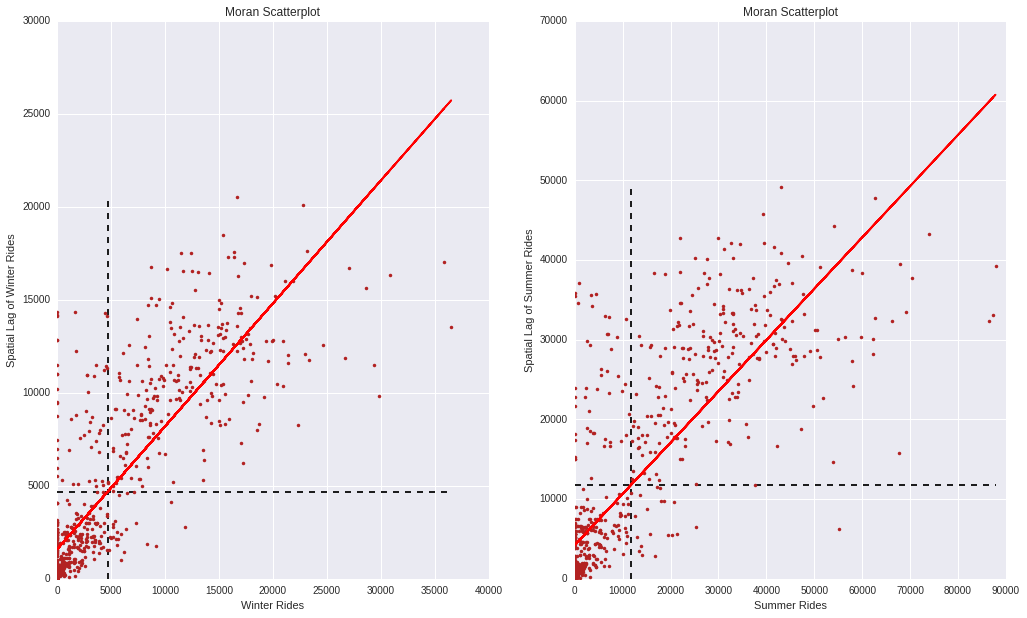

In [157]:
fig, ax = plt.subplots(1, 2, figsize=(17, 10))

#Plot the winter rides
ax[0].plot(WinterRide, WinterRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
ax[0].vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
ax[0].hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
ax[0].plot(WinterRide, a + b * WinterRide, 'r')
ax[0].set_title('Moran Scatterplot')
ax[0].set_ylabel('Spatial Lag of Winter Rides')
ax[0].set_xlabel('Winter Rides')


#Plot the SummerRides
ax[1].plot(SummerRide, SummerRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
ax[1].vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
ax[1].hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
ax[1].plot(SummerRide, a1 + b1 * SummerRide, 'r')
ax[1].set_title('Moran Scatterplot')
ax[1].set_ylabel('Spatial Lag of Summer Rides')
ax[1].set_xlabel('Summer Rides')

### Moran's I

In [158]:
I_WinterRide = ps.Moran(WinterRide, qW_CT)

In [159]:
I_SummerRide = ps.Moran(SummerRide, qW_CT)

In [160]:
I_WinterRide.I, I_WinterRide.p_sim

(0.66039156431885593, 0.001)

In [161]:
I_SummerRide.I, I_SummerRide.p_sim

(0.64353398667011008, 0.001)

The $I$ statistic for winter is is $0.66$ for this data, and has a very small $p$ value. 

The $I$ statistic for summer is is $0.644$ for this data, and has a very small $p$ value. 

In [162]:
I_WinterRide.sim[0:10]

array([-0.00461203,  0.01727224,  0.00286279,  0.01024935,  0.00734728,
        0.00952076,  0.01907806, -0.02142163, -0.00331526, -0.01243592])

In [163]:
I_SummerRide.sim[0:10]

array([-0.00833542, -0.01242682,  0.00588607,  0.01173782,  0.0014524 ,
        0.0087188 , -0.00090233,  0.02776199,  0.03272122,  0.04835693])

### KDEplot of all of the simulated winter points
the vertical line shows the observed value

In [165]:

plt.rcParams['figure.figsize']=(14,3)

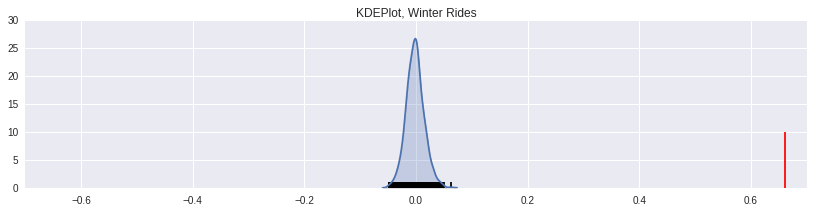

In [166]:
sns.kdeplot(I_WinterRide.sim, shade=True)
plt.vlines(I_WinterRide.sim, 0, 1)
plt.vlines(I_WinterRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])
plt.title('KDEPlot, Winter Rides')

### KDEplot of all of the simulated summer points
the vertical line shows the observed value

In [167]:
plt.rcParams['figure.figsize']=(14,3)

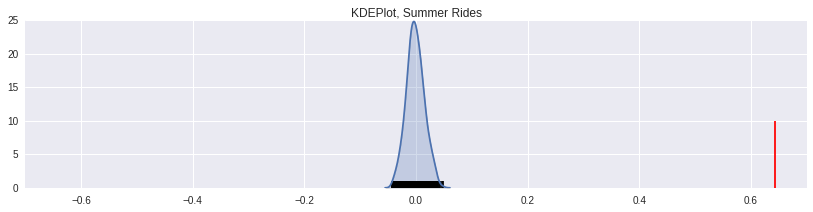

In [168]:
sns.kdeplot(I_SummerRide.sim, shade=True)
plt.vlines(I_SummerRide.sim, 0, 1)
plt.vlines(I_SummerRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])
plt.title('KDEPlot, Summer Rides')

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

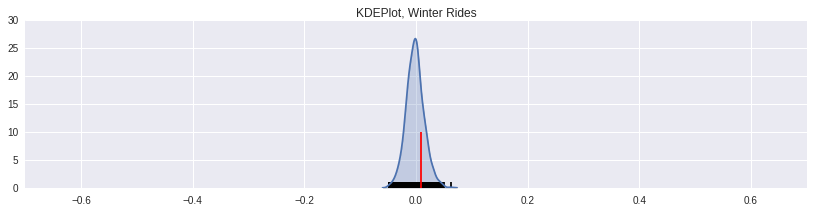

In [169]:
sns.kdeplot(I_WinterRide.sim, shade=True)
plt.vlines(I_WinterRide.sim, 0, 1)
plt.vlines(I_WinterRide.EI + .01, 0, 10, 'r')
plt.xlim([-.70, .70])
plt.title('KDEPlot, Winter Rides')

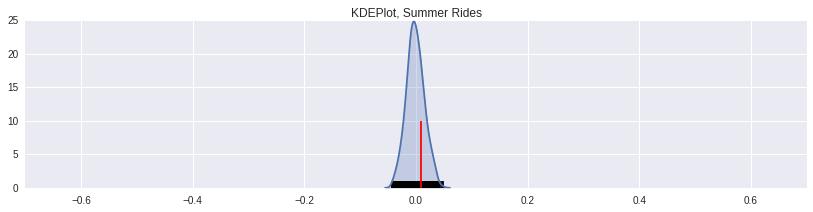

In [170]:
sns.kdeplot(I_SummerRide.sim, shade=True)
plt.vlines(I_SummerRide.sim, 0, 1)
plt.vlines(I_SummerRide.EI + .01, 0, 10, 'r')
plt.xlim([-.70, .70])
plt.title('KDEPlot, Summer Rides')

## Local  Spatial Autocorrelation

In [171]:
LMo_WinterRide = ps.Moran_Local(WinterRide, qW_CT,permutations=999)

In [172]:
LMo_SummerRide = ps.Moran_Local(SummerRide, qW_CT,permutations=999)

In [173]:
LMo_WinterRide.Is[0:5], LMo_WinterRide.p_sim[0:5]

(array([ -0.00000000e+00,  -3.14119985e-01,  -1.93084894e-04,
         -4.03594530e-03,  -7.97531288e-02]),
 array([ 0.001,  0.138,  0.495,  0.495,  0.406]))

In [174]:
LMo_SummerRide.Is[0:5], LMo_SummerRide.p_sim[0:5]

(array([-0.        , -0.2391325 ,  0.01474643,  0.00173718,  0.02473794]),
 array([ 0.001,  0.19 ,  0.323,  0.325,  0.358]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [179]:
Wsigs = WinterRide[LMo_WinterRide.p_sim <= .001]
W_sigs = WinterRideLag[LMo_WinterRide.p_sim <= .001]
Winsigs = WinterRide[LMo_WinterRide.p_sim > .001]
W_insigs = WinterRideLag[LMo_WinterRide.p_sim > .001]

In [180]:
Ssigs = SummerRide[LMo_SummerRide.p_sim <= .001]
S_sigs = SummerRideLag[LMo_SummerRide.p_sim <= .001]
Sinsigs = SummerRide[LMo_SummerRide.p_sim > .001]
S_insigs = SummerRideLag[LMo_SummerRide.p_sim > .001]

### Plot Signficant LISA

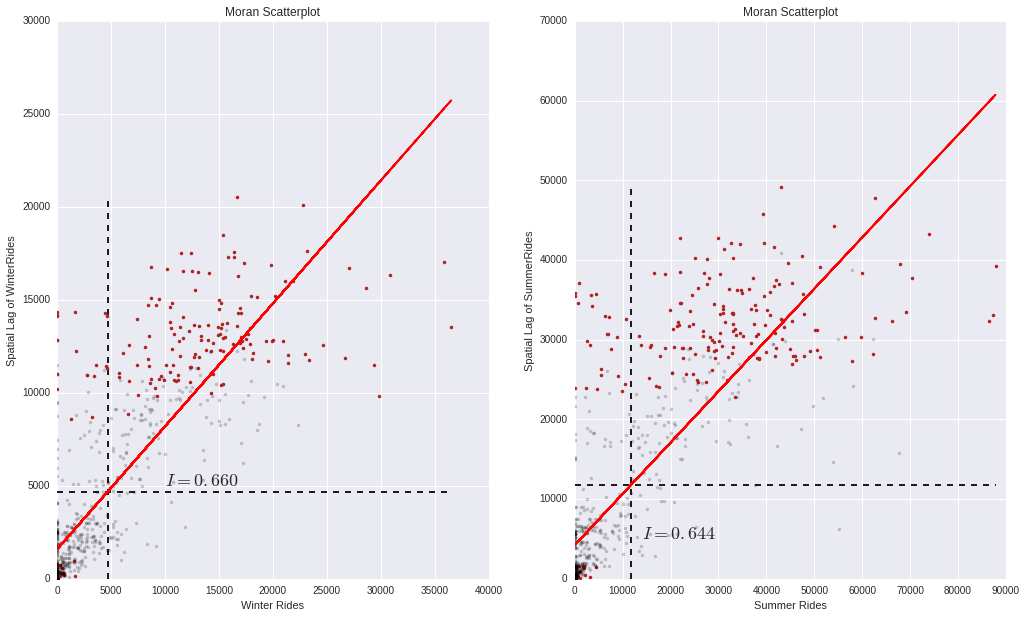

In [188]:
fig, ax = plt.subplots(1, 2, figsize=(17, 10))


ax[0].plot(Wsigs, W_sigs, '.', color='firebrick')
ax[0].plot(Winsigs, W_insigs, '.k', alpha = .2)
ax[0].text(s='$I = %.3f$' % I_WinterRide.I, x=10000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
ax[0].vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
ax[0].hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
ax[0].plot(WinterRide, a + b * WinterRide, 'r')
ax[0].set_title('Moran Scatterplot')
ax[0].set_ylabel('Spatial Lag of WinterRides')
ax[0].set_xlabel('Winter Rides')






ax[1].plot(Ssigs, S_sigs, '.', color='firebrick')
ax[1].plot(Sinsigs, S_insigs, '.k', alpha = .2)
ax[1].text(s='$I = %.3f$' % I_SummerRide.I, x = 14000, y = 5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
ax[1].vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
ax[1].hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
ax[1].plot(SummerRide, a1 + b1 * SummerRide, 'r')
ax[1].set_title('Moran Scatterplot')
ax[1].set_ylabel('Spatial Lag of SummerRides')
ax[1].set_xlabel('Summer Rides')


### Hot and Cold spots 

In [191]:
Wsig = LMo_WinterRide.p_sim < 0.01
Whotspots = LMo_WinterRide.q==1 * Wsig
Wcoldspots = LMo_WinterRide.q==3 * Wsig
print "Number of Winter Hotspots:", Whotspots.sum()
print "Number of Winter Coldspots:", Wcoldspots.sum()

Number of Winter Hotspots: 193
Number of Winter Coldspots: 208


In [192]:
Ssig = LMo_SummerRide.p_sim < 0.01
Shotspots = LMo_SummerRide.q == 1 * Ssig
Scoldspots = LMo_SummerRide.q == 3 * Ssig
print "Number of Summer Hotspots:", Shotspots.sum()
print "Number of Sumer Coldspots:", Scoldspots.sum()

Number of Summer Hotspots: 187
Number of Sumer Coldspots: 239


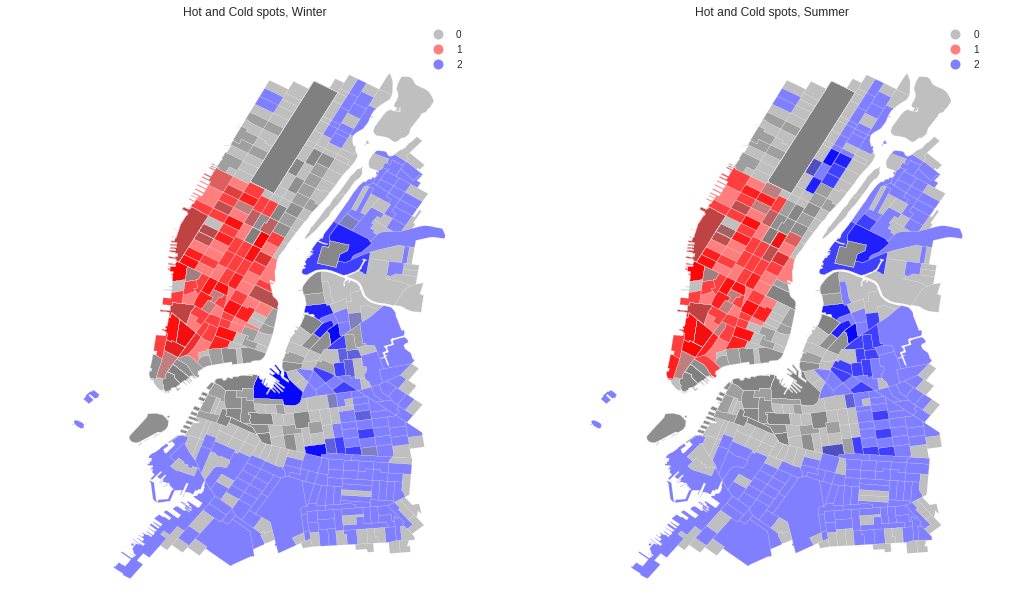

In [199]:
fig, ax = plt.subplots(1, 2, figsize=(17, 10))

hcmap = colors.ListedColormap(['grey','red','blue'])
Whotcold = Whotspots  * 1 + Wcoldspots * 2
Shotcold = Shotspots  * 1 + Scoldspots * 2



ct_shape_MonthlyAve_Zoom.assign(cl = Whotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax[0], 
        edgecolor='white', legend=True)
ax[0].set_axis_off()
plt.title("MonthlyAve Spatial Lag Deciles")
ax[0].set_title('Hot and Cold spots, Winter')

ct_shape_MonthlyAve_Zoom.assign(cl = Shotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax[1], 
        edgecolor='white', legend=True)
ax[1].set_axis_off()
ax[1].set_title('Hot and Cold spots, Summer')



###Comparison of Seasonal Differences with CitiBike ridership: 

Both season exhibit similar patterns of hot and cold spots with very little change between seasons. 

In the summer there is a significant Cold spot in the lower part of the Upper East Side. In the Winter the Brooklyn Navy Yard becomes a cold spot. 

From the map above it seems clear that there is not much difference in spatial correlation due to the change of season and thus weather.